In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from src.network import Network_custom
from src.printing import *
# G-code generation codes are cloned from https://github.com/tibor-barsi/GcodeGenerator. Tibor Barsi is the author of the code.
from src.g_code_generation_copy.gcode_generator import G_code_generator
from src.g_code_generation_copy.tool_changer_functions import load_params
from src.network import Network_custom#, replace_brackets
import os

Step 1) Define a rectangular network to be wrapped around a balloon. The tension gradient matched one for a cylinder loaded by an out of plane Moment.

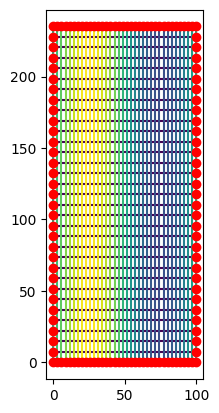

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def generate_grid_network(width, height, nx, ny, q_horizontals, q_verticals, dq):
    """
    Generate a rectangular grid network.
    
    Parameters:
    width (float): Width of the grid.
    height (float): Height of the grid.
    nx (int): Number of horizontal divisions.
    ny (int): Number of vertical divisions.
    q_horizontals (float): Force density for horizontal edges.
    q_verticals (float): Force density for vertical edges.
    dq (float): Amplitude of sine function modulation for vertical edges.
    
    Returns:
    vertices (np.ndarray): Array of vertex coordinates.
    edges (list): List of edges as index pairs.
    paths (list): List of edge sequences for printing.
    fixed (list): Indices of fixed vertices.
    q (np.ndarray): Array of force densities for each edge.
    """
    x_vals = np.linspace(0, width, nx + 1)
    y_vals = np.linspace(0, height, ny + 1)
    vertices = np.array([[x, y, 0] for y in y_vals for x in x_vals])
    
    edges = []
    paths = []
    q = []
    
    # Horizontal paths
    for j in range(ny + 1):
        path = []
        for i in range(nx):
            idx1 = j * (nx + 1) + i
            idx2 = idx1 + 1
            edges.append([idx1, idx2])
            q.append(q_horizontals)
            path.append(len(edges) - 1)
        paths.append(path)
    
    # Vertical paths (excluding last column)
    for i in range(nx + 1):
        path = []
        theta = np.sin(i * 2 * np.pi / (nx))
        for j in range(ny):
            idx1 = j * (nx + 1) + i
            idx2 = idx1 + (nx + 1)
            # if i < nx:  # Exclude last vertical column
            edges.append([idx1, idx2])
            q.append(q_verticals + dq * theta)
            path.append(len(edges) - 1)
        # if i < nx:
        paths.append(path)
    
    # Fixed points (edge points excluding rightmost edge)
    fixed = [i for i in range(len(vertices)) if i % (nx + 1) == 0 or i < (nx + 1) or i >= (ny * (nx + 1)) or i % (nx + 1) == nx]
    
    return vertices, edges, paths, fixed, np.array(q)

# Example usage:
width, height, nx, ny = 100, 235, 35, 32
q_horizontals, q_verticals, dq = 0.035, 0.16, 0.076
vertices, edges, paths, fixed, q = generate_grid_network(width, height, nx, ny, q_horizontals, q_verticals, dq)

q_min, q_max = np.min(q), np.max(q)
color_func = lambda q: (q - q_min) / (q_max - q_min)
# Plotting
fig, ax = plt.subplots()
ax.set_aspect('equal')
for (i, j), q_i in zip(edges, q):
    ax.plot([vertices[i, 0], vertices[j, 0]], [vertices[i, 1], vertices[j, 1]], color=plt.cm.viridis(color_func(q_i)))
for i in fixed:
    ax.plot(vertices[i, 0], vertices[i, 1], 'ro')
plt.show()

Open the network in the custom network class. The class finds the equilibriated network (which it already was)

In [3]:
model_name = "balloonbender9000"
directions = np.ones(len(edges))
net = Network_custom.from_fd(vertices, edges, q, fixed, paths = paths, dir = directions)
net.auto_flip_curves(n = 20) # Automatically flip the curvature of the edges
net.net_plot(color = True) #, path_colors=True)

In [4]:
file_path = os.path.join('DATA', 'Avg_Stress_Strain_Overture_TPU.csv')
stress_data, strain_data = net.load_stress_strain_curve(file_path)
TPU_nl = {'stress':strain_data, 'strain': stress_data, 'v':0.3897, 'p':1.18e-9, 'A': 0.078294515, 'name': 'TPU Overture'} # TPU Overture non-conductive
net.set_material(TPU_nl) # By saving the material properties in the network, we can easily see how the network was constructed.

A = [TPU_nl['A']]*len(net.edges)
A = np.array(A)
A[ny+1:] *= 3 # The vertical edges will be printed from 3 layers, such that higher bending moments can be achieved.
l0, l_scalar = net.materialize_nonlinear(A, stress_data, strain_data, interpolation_kind = 'cubic')

In [5]:
net.initialize_shape_optimizer(function_type = 'standard',  method = 'Gauss-Seidel',options ={"maxiter": 100000, "damping": .9, "tol": 1e-6})
net.optimize_vertices()

Iteration 0: Current error = 1272.1385209739374
Iteration 100: Current error = 166.5051134290579
Iteration 200: Current error = 38.33963909259929
Iteration 300: Current error = 10.940096467474422
Iteration 400: Current error = 3.6726708421104464
Iteration 500: Current error = 1.4376779165209115
Iteration 600: Current error = 0.6485155113260855
Iteration 700: Current error = 0.32157270347760275
Iteration 800: Current error = 0.17151304631493453
Iteration 900: Current error = 0.09773177909137867
Iteration 1000: Current error = 0.05618099230580844
Iteration 1100: Current error = 0.03249753025400636
Iteration 1200: Current error = 0.019354092167966908
Iteration 1300: Current error = 0.011622248332846682
Iteration 1400: Current error = 0.007059285970811101
Converged after 1416 iterations.
Final error: 0.006532271604184627


In [6]:

reference_point = [0,0,0]                         # The network will be scaler relative to this point
net.scale_vertices(reference_point, net.l_scalar, account_for_leafs=False) # If you don't provide a scalar, it will use network.l_scalar automatically. Note, that in this particular case, there are no leafs, so the last argument is not necessary.

#  You can plot the scaled network like this
# net.net_plot(color=True, plot_type='scaled')

R, th = net.arc_param()
xyz = net.arc_points() 

net.net_plot(color=True, plot_type='arcs', elables=False)

In [7]:
%matplotlib qt
ani = net.ShapeOptimizer.animate_optimization(frame_range  = range(0, len(net.ShapeOptimizer.history), 10))

- Everytime a path intersects a previous path, the nozzle will jump:

In [8]:
printing_params = load_params(r'DATA/NT_Eel_0.2mm.json')
net.jump_at_intersection(intersection_width = printing_params['d_nozzle']*1.5, intersection_height = printing_params['layer_height'], interpolation_function=None) 

- To connect the mesh to a ring loops are added at the top and bottom:

In [9]:
alpha_loop = np.deg2rad(40) # The angle of the loop
L_loop  = 3.2                # The length of the loop
n_points = 18               # The number of points in the loop

start_loop_bools = np.zeros(len(paths), dtype = bool)
end_loop_bools = np.zeros(len(paths), dtype = bool)
start_loop_bools[ny+1:] = True #vertical
end_loop_bools[ny+1:] = True #vertical

net.all_loop_to_path(start_loop_bools, end_loop_bools, L_loop, alpha_loop, n_points)

# Generate Gcode
- start gcode copied from file

In [17]:
printing_params = load_params(r'DATA/NT_Eel_0.2mm.json')
start_gcode     = open(r'DATA/start_gcode_Prusa.gcode', 'r').read()
end_gcode       = open(r'DATA/end_gcode_Prusa.gcode', 'r').read()

temperature_settings = {'first_layer_bed_temperature': 65, 'first_layer_temperature':205, 'K-factor': 0.20}
g_code = replace_brackets(start_gcode, temperature_settings)

comment = ''

bed_width = 230
bed_height = 210

gen = G_code_generator(printing_params=printing_params)

- Add a purge line

In [18]:
point0, point1 = [-5,3,0.3], [-5,200,0.3]

g_code += make_purge_line(printing_params, gen, point0, point1)

- Loop through every path and add gcode

In [ ]:
for path_i, cor_list in enumerate(net.paths_xyz):
    cor_list[:,0] += bed_width/2 
    cor_list[:,1] += bed_height/2 
    g_code += add_path_to_gcode(cor_list, gen, printing_params, comment = 'Path (' + str(path_i) + ')')


- Add two additinal layers at all vertical path to ensure vertical lines have 3*A cross sectional area

In [20]:
lh_copy =  printing_params['layer_height']

additional_layers = 2
for al_i in range(2, additional_layers + 2):
    printing_params['layer_height'] = al_i * lh_copy
    for path_i, cor_list in enumerate(net.paths_xyz[ny+1:]):
        g_code += add_path_to_gcode(cor_list, gen, printing_params, comment = 'Path (' + str(path_i) + ')')

printing_params['layer_height'] = lh_copy

- Write gcode to file

In [21]:
g_code += end_gcode
save_gcode(os.path.join('DATA', 'generated_gcodes', model_name + '.gcode'), g_code)
print('G-code generated')

G-code generated


- Networks can be save like this if desired:

In [15]:
# net.save_network(os.path.join('networks', model_name + '_net.pkl'))